4.1 CNN 원리
--------

- CNN의 원리
- 필기체를 분류하는 CNN 구현
- 컬러 이미지를 분류하는 CNN 구현

### 4.1 CNN의 원리

CNN은 convolution filter(합성곱 필터)를 이용하여 신경망 동작을 수행
- 여러 작은 필터가 이미지 위를 돌아다니면서 특징점들을 찾아 그 합성곱 결과를 다음 계층으로 보냄
- 적은 수의 가중치로 이미지 처리를 효율적으로 할 수 있음

CNN은 입력 부근 계층들을 합성곱 계층으로 구성하고, 출력 부근 계층들을 fully connectd layer로 구성
- CNN을 구성하는 계층 중에 합성곱 계층들은 특징점을 효과적으로 찾는 데 활용되고, fully connectd layer들은 찾은 특정점을 기반으로 이미지를 분류하는 데 주로 활용

CNN은 2차원이나 그 이상 차원의 데이터 처리에 적합

![alt text](https://e2e.ti.com/cfs-file/__key/communityserver-blogs-components-weblogfiles/00-00-00-08-94/TIDL-CNN.PNG)

#### CNN vs DNN

- DNN은 이미지를 1차원 벡터로 변환하여 전 계층이 1차원 방식으로 신호를 처리하기 때문에 2차원 특성을 처리하기에는 한계가 있음
- CNN은 2차원 convolution(합성곱)으로 각 노드를 처리하기 때문에 이미지에 더 적합
  - CNN은 이미지의 높이와 넓이를 생각하면서 2차원 처리를 수행
  - 컬러 이미지를 다룰 경우 컬러에 대한 계층은 깊이(depth)라는 별도의 차원으로 관리
  - Convoluton layer가 끝나면 Maxpooling layer를 이용해 각 지역별로 최대값을 찾아줌
  - 이렇게 하면 특징점 위치가 약간씩 달라져도 딥러닝을 제대로 수행 가능해지게 됨
  
![alt text](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

### 4.2 필기체를 분류하는 CNN 구현

#### 4.2.1 분류 CNN 모델링

convolution layer와 fully connected layer를 결합하여 구성된 분류 CNN 모델링


In [3]:
import keras
from keras import models, layers

CNN에 사용하는 layer와 내부 패키지

- Dense
- Dropout
- Conv2D : 2차원 합성곱을 계산하는 클래스
- MaxPooling2D : 2차원 맥스풀링을 계산하는 클래스
- Flatten : 다차원의 입력을 1차원의 입력으로 변환하는 클래스


CNN에서는 filter를 kernerl이라고 부르기도 한다.
- 아래 layers.Conv2D의 docs를 보면 fiters, kernel_size 이렇게 써있는데...
- 이해하면 결국 filter size를 의미하는 것이다.

In [4]:
# 딥러닝 엔진 직접 제어 가능

from keras import backend

In [5]:
layers.Conv2D?

Init signature:
layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
2D convolution layer (e.g. spatial convolution over images).

This layer creates a convolution kernel that is convolved
with the layer input to produce a tensor of
outputs. If `use_bias` is True,
a bias vector is created and added to the outputs. Finally, if
`activation` is not `None`, it is applied to the outputs as well.

When using this layer as the first layer in a model,
provide the keyword argument `input_shape`
(tuple of integers, does not include the sample axis),
e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
in `data_format="channels_last"

In [6]:
class model(models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()   # 기본 특성을 상속한 부모 함수를 부름 models.Sequential.__init__(self) 와 동일
      
    
        """
        첫 번째 은닉 계층 정의 부분에서는 자신의 형태뿐 아니라 입력 계층의 형태를 동시에 설정
        아래 layers.Conv2D의 docs를 보면 fiters, kernel_size 이렇게 써있는데...
        이해하면 결국 filter size를 의미하는 것이다.
        
        입력 계층의 형태는 객체의 초기화 변수인 input_shape를 따름
        초기화 함수의 입력값이므로 모델의 인스턴스를 만들 때 정해집니다.
        
        합성곱 계층은 input_shape가 2차원 이미지들로 구성된다는 점, RGB로 여러 색상을 표현하기 때문에 input_shape의 길이가 3인 리스트
        """
        self.add(layers.Conv2D(
            32, kernel_size=(3,3),
            activation='relu',
            input_shape=input_shape))

        """
        특이 사항 : 커널 수 64개
        MaxPool2D : 합성곱을 한 뒤에 인접한 2 * 2 셀들을 묶어서 가장 큰 값만 내보내는 부속 계층
        부속 계층은 학습을 통해 가중치가 바뀌는 형태는 아니지만 입력 신호를 특정한 형태로 변화시키는 계층
        
        dropout : 0.25
        Flatten : 입력을 벡터로 바꿉니다. 2차원 벡터를 1차원 벡터로 변환 시킵니다.
        """
        self.add(layers.Conv2D(64, (3,3), activation='relu'))
        self.add(layers.MaxPool2D(pool_size=(2,2)))
        self.add(layers.Dropout(0.25))
        self.add(layers.Flatten())

        """
        앞의 두 개의 Conv2D layer는 이미지의 특징점을 잘 찾기 위한 것
        """
        self.add(layers.Dense(128, activation='relu'))
        self.add(layers.Dropout(0.5))
        self.add(layers.Dense(num_classes, activation='softmax'))


        self.compile(
            loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy']
        )

### 4.2.2 분류 CNN을 위한 데이터 준비

- x_train, x_test : 학습 및 성능 평가에 사용할 필기체 이미지 변수들의 배열
- y_train, y_test : 학습과 성능 평가에 사용할 필기체 이미지의 레이블 정보의 배열

#### DNN과 CNN의 데이터 준비 차이

1. 이미지를 벡터화 하지 않고 그대로 사용, 2차원 이미지를 1차원으로 변환하지 않음
2. 흑백 이미지의 채널 정보를 처리하려면 추가적인 차원을 이미지 데이터에 포함해야 합니다.
  - 컬러 이미지는 RGB색상을 다루는 채널정보가 이미지 데이터에 이미 포함되어 있어 이미지를 나타내는 각 입력 데이터가 3차원으로 구성
  - 흑백 이미지는 채널 정보가 존재하지 않아서 입력 데이터의 차원을 하나 더 추가해야 함.

In [7]:
from keras import datasets

In [8]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

채널은 이미지 배열의 앞 단에 추가되어야 할 수도 있고, 뒷 단에 추가되어야 할 수도 있습니다.
- 케라스의 시스템 파라미터인 'image_data_format'으로 지정

```python3
x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
- x_train.shape[0] : 샘플 수
- 1 : 채널 수
- img_rows : 이미지의 가로 길이
- img_cols : 이미지의 세로 길이로 구성
```

In [16]:
if backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols) # 채널 이미지 정보가 앞에 들어감
    
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1) # 채널 이미지 정보가 끝에 들어감

### 4.2.3 학습 효과 분석

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
def plot_acc(history, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


### 4.2.4 분류 CNN 학습 및 성능 평가

In [19]:
import keras
import matplotlib.pyplot as plt
from keras import models, layers
from keras import backend
from keras import datasets

%matplotlib inline

In [61]:
layers.Conv2D?

Init signature:
layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs,
)
Docstring:     
2D convolution layer (e.g. spatial convolution over images).

This layer creates a convolution kernel that is convolved
with the layer input to produce a tensor of
outputs. If `use_bias` is True,
a bias vector is created and added to the outputs. Finally, if
`activation` is not `None`, it is applied to the outputs as well.

When using this layer as the first layer in a model,
provide the keyword argument `input_shape`
(tuple of integers, does not include the sample axis),
e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
in `data_format="channels_last"

In [83]:
# CNN modeling : classification

class CNN(models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(layers.Conv2D(
            filters=32,
            kernel_size=(3,3),
            activation='relu',
            input_shape=input_shape))
        
        self.add(layers.Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='relu'))
        self.add(layers.MaxPool2D(pool_size=(2,2)))
        self.add(layers.Dropout(0.25))
        self.add(layers.Flatten())
        
        self.add(layers.Dense(128, activation='relu'))
        self.add(layers.Dropout(0.5))
        self.add(layers.Dense(num_classes, activation='softmax'))
        
        self.compile(
            loss=keras.losses.categorical_crossentropy,
            optimizer='rmsprop',
            metrics=['accuracy']
        )

In [89]:
# Set the dataset for modeling : classification

class DATA():
    def __init__(self):
        num_classes = 10
        
        (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
        
        img_rows, img_cols = X_train.shape[1:] # (60000, 28, 28) -> (28, 28)
        
        print(backend.image_data_format())
        
        if backend.image_data_format() == 'channels_first':
            X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
            X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
            
        else:
            X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
            X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
            
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        
        X_train /= 255
        X_test /= 255
        
        
        """
        to_categorical
            keras.utils.to_categorical(y, num_classes=None, dtype='float32')
            Converts a class vector (integers) to binary class matrix.

            E.g. for use with categorical_crossentropy.

            Arguments

            y: class vector to be converted into a matrix (integers from 0 to num_classes).
            num_classes: total number of classes.
            dtype: The data type expected by the input, as a string (float32, float64, int32...)
            Returns

            A binary matrix representation of the input. The classes axis is placed last.
        """
        
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
        
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test

In [90]:
result = DATA()
print(result)
print(result.input_shape)

channels_last
(28, 28, 1)


channels_last
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.1931 - acc: 0.9416 - val_loss: 0.0628 - val_acc: 0.9822
Epoch 2/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.0954 - acc: 0.9727 - val_loss: 0.0623 - val_acc: 0.9830
Epoch 3/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.0926 - acc: 0.9744 - val_loss: 0.0674 - val_acc: 0.9821
Epoch 4/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.0972 - acc: 0.9731 - val_loss: 0.0606 - val_acc: 0.9826
Epoch 5/10
48000/48000 [==============================] - 86s 2ms/step - loss: 0.0991 - acc: 0.9728 - val_loss: 0.0784 - val_acc: 0.9795
Epoch 6/10
48000/48000 [==============================] - 84s 2ms/step - loss: 0.1096 - acc: 0.9714 - val_loss: 0.0690 - val_acc: 0.9827
Epoch 7/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.1163 - acc: 0.9698 - val_loss: 0.

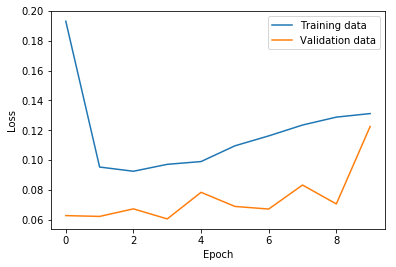

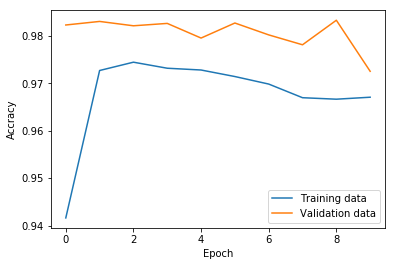

In [91]:
# 분류 CNN 학습 및 성능 평가

def main():
    batch_size = 20
    epochs = 10
    
    data = DATA()
    model = CNN(data.input_shape, data.num_classes)
    
    history = model.fit(
        data.X_train,
        data.y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2
    )
    
    score = model.evaluate(data.X_test, data.y_test)
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    plot_loss(history)
    plt.show()
    plot_acc(history)
    plt.show()
    

if __name__ == '__main__':
    main()

---------------------

### 4.3 분류 CNN 학습 및 성능 평가

1. 분류 CNN 패키지 임포트
2. 분류 CNN 모델링
3. 분류 CNN을 위한 데이터 준비
4. 분류 CNN의 학습 및 성능 평가를 위한 머신 클래스
5. 분류 CNN의 수행

### 4.3.1 분류 CNN 패키지 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from kerasapp import skeras # 학습 곡선을 그리는 plot_loss(), plot_acc()를 모아 둔 파일
from kerasapp import sfile # 학습 결과 저장하는 함수

Using TensorFlow backend.


### 4.3.2 분류 CNN 모델링

#### LeNet
- LeNet 신경망은 레쿤 교수 팀에서 만든 합성곱 방식 인공신경망
- 합성곱 계층 두 개와 완전 연결 계층 하나로 구성

![alt text](https://t1.daumcdn.net/cfile/tistory/2777003557AB5C0634)

In [2]:
# layers.Input?

#### 모델 기본 구조

```python
class CNN(Model):
    def __init__(model, nb_classes, in_shape=None):
        model.nb_classes = nb_classes
        model.in_shape = in_shape
        model.build_model()
        
        super().__init__(model.x, model.y)
        model.compile()
```

- 초기화 함수의 argu 로 nb_classes, in_shape의 값을 설정
- build_model()로 모델을 만듬
- 부모 클래스 초기화 함수 super().__init__()
- 구성 모델을 compile함

#### 입력 계층 및 은닉 계층 정의

```python
def build_model(model):
    nb_classes = model.nb_classes
    in_shape = model.in_shape
    
    x = Input(in_shape)
    h = Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=in_shape)(x)
    h = Conv2D(64, (3, 3), activation='relu')(h)
    
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Dropout(0.25)(h)
    h = Flatten()(h)
    
    z_cl = h
    
    h = Densc(128, activation='relu')(h)
    h = Dropout(0.5)(h)
    
    z_fl = h
    
    y = Dense(nb_classes, activation='softmax', name='preds')(h)
    model.cl_part = Model(x, z_cl)
    model.fl_part = Model(x, z_fl)
    
    model.x, model.y = x, y
```

- 주어진 입력 이미지의 크기를 처리하는 입력 계층을 정의
- 그 다음은 fully connected layeer로 구성된 hidden layer 두 개 정의
- 두 hidden layer 모두 (3, 3) 크기로 구성된 convolution filter를 사용, activation='relu'

#### flatten
- 3차원 텐서를 1차원 벡터로 바꾸는 flatten
- convolution은 3차원을 다루지만 fully connected layer는 1차원을 다루므로 변환 작업이 필요
- 위의 코드에 넣어둠


#### MaxPooling
- (2,2) 크기의 블록 단위로 가장 큰 값을 찾아냄
- 이 작업을 마치면 입력 크기가 가로 세로 두 축으로 각각 반씩 줄어듬
- 결과가 어떻게 나올까...는 이 분 블로그 보고 참고 하였다
  - https://seongkyun.github.io/study/2019/01/25/num_of_parameters/

In [3]:
# CNN은 모델의 일종이므로 케라스의 Model 클래스를 상속해서 만들었음

class CNN(Model):
    def __init__(model, nb_classes, in_shape=None):
        model.nb_classes = nb_classes
        model.in_shape = in_shape
        model.build_model() # 모델 만들기
        super().__init__(model.x, model.y)
        model.compile()
        
    def build_model(model):
        nb_classes = model.nb_classes
        in_shape = model.in_shape
        
        
        """
        주어진 입력 이미지의 크기를 처리하는 입력 계층을 정의
        그 다음은 완전 연결 계층으로 구성된 은닉 계층 두 개를 정의
        두 은닉 계층 모두 (3, 3) 크기로 구성된 합성곱 필터를 사용
        """
        x = Input(in_shape)
        h = Conv2D(
            32, 
            kernel_size=(3, 3), 
            activation='relu',
            input_shape=in_shape)(x)
        
        h = Conv2D(
            64,
            (3, 3),
            activation='relu')(h)
        
        """
        합성곱 계층의 처리 결과를 완전 연결 계층으로 보내기 위해 3차원 텐서를 1차원 벡터로 바꾸는 Flatten 작업
        맥스풀링 작업이 마치고 나면 입력 크기가 가로 세로 두 축으로 각각 반씩 줄어듭니다.
        여기까지 작업 한 것이 합성곱 계층의 출력임을 변수 z_c1을 사용해서 저장
        이렇게 해두면 x와 z_c1 사이의 모델을 만들면 추후 합성곱 계층을 지난 결과를 별도로 분석 할 수 있음
        """
        h = MaxPooling2D(pool_size=(2,2))(h)
        h = Dropout(0.25)(h)
        h = Flatten()(h)
        z_c1 = h
        
        """
        완전 연결 계층은 128개 노드로 구성되었으며, Relu를 활성화 함수로 사용
        출력 계층으로 나가기 전의 완전 연결 계층 출력도 별도로 저장, z_f1 = h
        """
        h = Dense(128, activation='relu')(h)
        h = Dropout(0.5)(h)
        z_f1 = h
        
        """
        출력 계층을 nb_classes에 해당하는 만큼의 노드 수로 구성, 활성화 함수 소프트맥스로 지정
        z_c1, z_f1을 이용해 부가적인 2가지 모델 생성
        또한 본 모델을 만들 수 있도록 입력과 출력을 멤버 변수로 정의
        """
        y = Dense(nb_classes, activation='softmax', name='preds')(h)
        
        model.c1_part = Model(x, z_c1)
        model.f1_part = Model(x, z_f1)
        
        model.x, model.y = x, y
        
    def compile(model):
        Model.compile(
            model,
            loss='categorical_crossentropy',
            optimizer='adadelta',
            metrics=['accuracy']
        )

### 4.3.3 분류 CNN을 위한 데이터 준비

In [4]:
class Dataset():
    def __init__(self, X, y, nb_classes, scaling=True, test_size=0.2, random_state=0):
        """
        X is originally vector. Hence, it will be transformed to 2D images with a channel.
        """
        
        
        """
        self.add_channels()에 입력값을 전달하는 방법보다는 self.X를 이용해 채널을 더하는 작업이 진행 됨
        """
        self.X = X
        self.add_channels()        
        X = self.X
        
        
        # the data, shuffled and split between train and test sets
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=random_state)
        
        print(X_train.shape, y_train.shape)
        
        # 이미지 데이터가 정수인 경우가 있으므로 32비트 실수로 변경
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        
        if scaling:
            # scaling to have (0, 1) for each feature(each pixel)
            
            scaler = MinMaxScaler()
            
            n = X_train.shape[0]
            X_train = scaler.fit_transform(X_train.reshape(n, -1)).reshape(X_train.shape)
            
            n = X_test.shape[0]
            X_test = scaler.transform(X_test.reshape(n, -1)).reshape(X_test.shape)
            
            self.scaler = scaler
            
        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_test.shape[0], 'test samples')
        
        # convert class vectors to binary class matrices
        
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)
        
        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.y_train, self.y_test = y_train, y_test
        
    def add_channels(self):
        X = self.X
        
        if len(X.shape) == 3:
            N, img_rows, img_cols = X.shape
            
            # 케라스의 환경 변수인 image_dim_ordering이 'th', 즉 시에노 방식이라면 채널 정보를 길이 정보 바로 다음 두 번째 차원에 삽입
            # 텐서플로우 방식일 경우 맨 마지막에 넣어줌
            
            if K.image_dim_ordering == 'th': # K is keras backend
                X = X.reshape(X.shape[0], 1, img_rows, img_cols)
                input_shape = (1, img_rows, img_cols)
            else:
                X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                input_shape = (img_rows, img_cols, 1)
        else:
            input_shape = X.shape[1:] # channel is already included
            
        self.X = X
        self.input_shape = input_shape

#### 4.3.4 분류 CNN의 학습 및 성능 평가를 위한 머신 클래스 구현

Machine은 학습 및 성능 평가 코드가 들어 있는 클래스

In [5]:
class Machine():
    def __init__(self, X, y, nb_classes=2, fig=True):
        self.nb_classes = nb_classes
        self.set_data(X, y) # 데이터를 설정하는 함수
        self.set_model() # model을 설정하는 함수
        self.fig = fig # data 처리, model 생성 수행 결과를 그림으로 보여줄지를 클래스 전체에 영향을 주는 변수로 할당
        
    def set_data(self, X, y):
        nb_classes = self.nb_classes
        self.data = DataSet(X, y, nb_classes)
        
    def set_model(self):
        nb_classes = self.nb_classes
        data = self.data
        self.model = CNN(nb_classes=nb_classes, in_shape=data.input_shape)
        
    def fit(self, nb_epoch=10, batch_size=128, verbose=1):
        # nb_epoch 에포크, batch_size 학습 시 한 번에 처리할 블록 길이, verbose 진행 사항 표시
        data = self.data
        model = self.model
        
        history = model.fit(
            data.X_train, data.Y_train,
            batch_size=batch_size, epoch=nb_epoch,
            verbose=verbose, validation_data=(data.X_test, data.Y_test)
        )
        
        return history
            
    # 학습과 성능 평가 전체를 진행하는 run() 함수
    def run(self, nb_epoch=10, batch_size=128, verbose=1):
        data = self.data
        model = self,model
        fig = self.fig
        
        history = self.fit(nb_epoch=nb_epoch, batch_size=batch_size, verbose=verbose)
        score = model.evaluate(data.X_test, data.Y_test, verbose=0)
        
        print('Confusion matrix')
        
        Y_test_pred = model.predict(data.X_test, verbose=0)
        
        # 예측을 하게 되면 노드별로 이진값으로 결과가 출력되기 때문에 인덱스를 나타내는 정수 벡터로 바꿀 필요가 있다.
        y_test_pred = np.argmax(Y_test_pred, axis=1)
        print(metrics.confusion_matrix(data.y_test, y_test_pred))
        
        print('Test Score:', score[0])
        print('Test accuracy:', score[1])
        
        
        # Save results
        
        suffix = sfile.unique_file_name('datatime')
        foldname = 'output_' + suffix
        skeras.save_history_history(
            'history_history.npy', history.history, fold=foldname)
        
        # 학습 모델의 가중치 저장
        model.save_weights(os.path.join(foldname, 'dl_model.h5'))
        print('Output results are saved in', foldname)
        
        if fig:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            skeras.plot_acc(history)
            plt.subplot(1, 2, 2)
            skeras.plot_loss(history)
            plt.show()

        self.history = history

        return foldname

#### 4.3.5 분류 CNN의 학습 및 성능 평가 수행

In [6]:
from keras import datasets
from kerasapp import aicnn
import keras

In [7]:
# image_data_format을 channel_last로 가정했으므로 만약 channels_first로 설정된 경우 오류 내도록 코드 구현

assert keras.backend.image_data_format() == 'channels_last'

In [8]:
keras.backend.image_data_format?

Signature: keras.backend.image_data_format()
Docstring:
Returns the default image data format convention ('channels_first' or 'channels_last').

# Returns
    A string, either `'channels_first'` or `'channels_last'`

# Example
```python
    >>> keras.backend.image_data_format()
    'channels_first'
```
File:      /opt/conda/lib/python3.7/site-packages/keras/backend/common.py
Type:      function


In [9]:
class Machine(aicnn.Machine):
    def __init__(self):
        (X, y), (x_test, y_test) = datasets.cifar10.load_data()
        super().__init__(X, y, nb_classes=10)

(40000, 32, 32, 3) (40000, 1)
X_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
data.input_shape (32, 32, 3)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 96s 2ms/step - loss: 1.8443 - acc: 0.3342 - val_loss: 1.4477 - val_acc: 0.4845
Epoch 2/100
40000/40000 [==============================] - 94s 2ms/step - loss: 1.4175 - acc: 0.4939 - val_loss: 1.3154 - val_acc: 0.5405
Epoch 3/100
40000/40000 [==============================] - 94s 2ms/step - loss: 1.2248 - acc: 0.5691 - val_loss: 1.1408 - val_acc: 0.5911
Epoch 4/100
40000/40000 [==============================] - 93s 2ms/step - loss: 1.0904 - acc: 0.6179 - val_loss: 0.9945 - val_acc: 0.6508
Epoch 5/100
40000/40000 [======

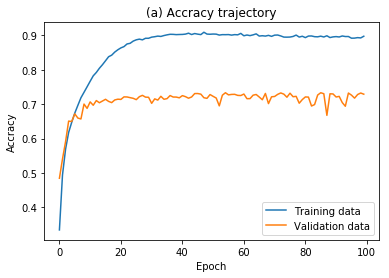

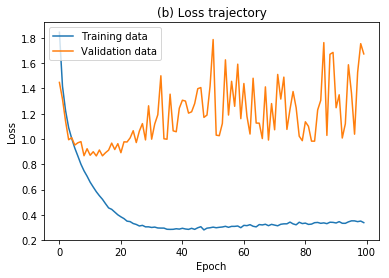

In [10]:
def main():
    m = Machine()
    m.run()
    

if __name__=='__main__':
    main()